# *Xeus-Octave*: A native Octave kernel for jupyter with advanced visualization

*Xeus-Octave* is an Octave kernel for Jupyter built with Xeus, a C++ framework
for building Jupyter kernels, which means that it is completely native, and does
not run a virtual Octave session in a forked process.

Thanks to its being native, xeus-octave has access to the internal representation
of all Octave objects, and thus it is able to provide advanced visualisation of
many types with ease.

## Native Octave plots

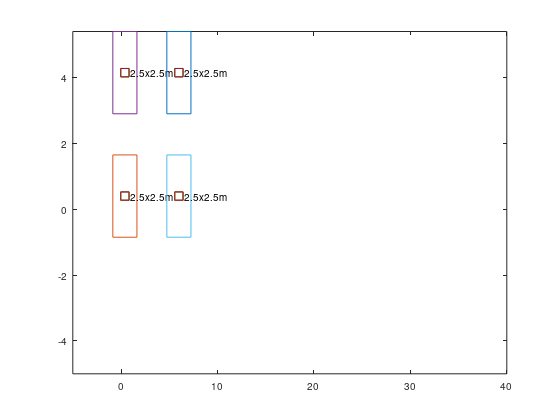

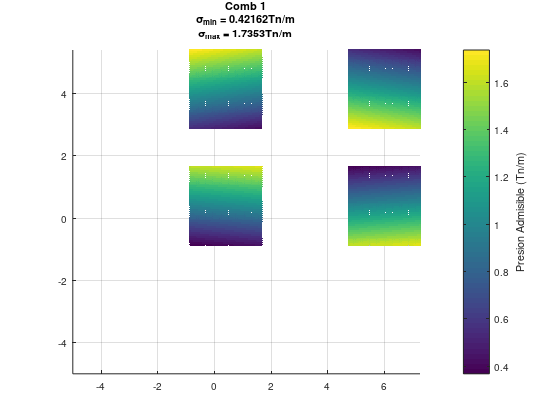

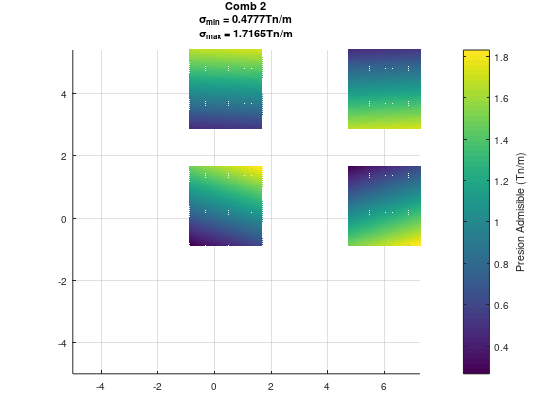

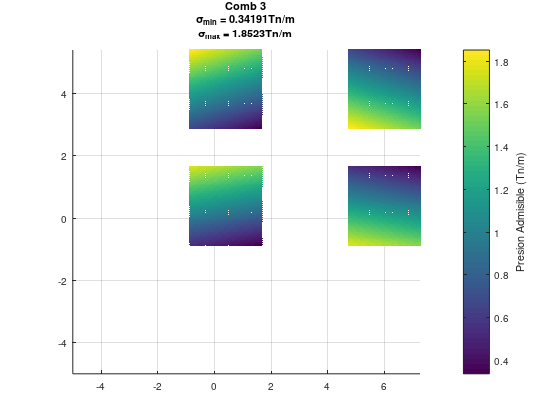

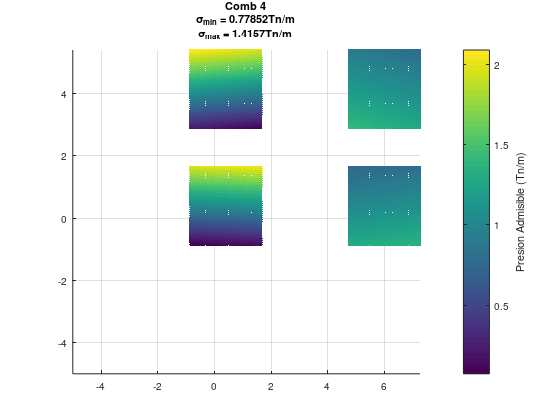

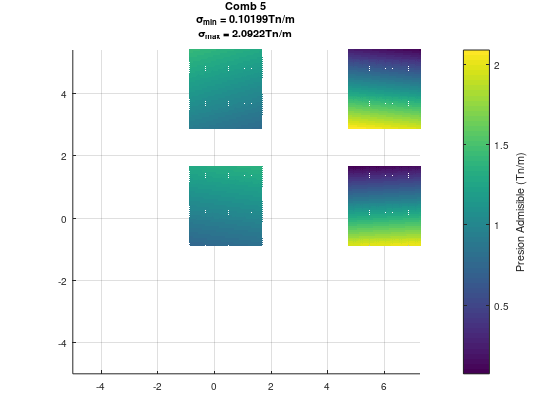

DIM,1,2,3
1,0,2.5,2.5
2,0,2.5,2.5
3,0,2.5,2.5
4,0,2.5,2.5


ERROR: received unknown message
Message type: usage_request


In [9]:
graphics_toolkit("notebook")
% Matriz de carga sismica
SISMO = [11, 0.2262, 0.3598, 0.8705;
         14, 0.1165, 0.2561, 0.8809;
         17, 0.2262, 0.3598, 0.8705;
         20, 0.1165, 0.2561, 0.8809];

% Matriz de carga muerta mas carga viva
PDPL = [11, 6.3254, 0.0926, 1.583;
        14, 6.7403, -0.1768, 1.5337;
        17, 6.3254, 0.0926, -1.583;
        20, 6.7403, -0.1768, -1.5337];

% Matriz de posiciones
a = [11, 0.4, 0.4;
     14, 0.4, 4.15;
     17, 6, 0.4;
     20, 6, 4.15]; % matriz de etiqueta y ubicacion

% Codigo para el calculo de combinaciones de carga
Co = zeros(5, 3 * length(a)); % Matriz combinacion de todas las cargas

for PO = 1:length(a)
    % CARGAS sismicas
    PS  = SISMO(PO, 2);
    MXS = SISMO(PO, 3);
    MYS = SISMO(PO, 4);
    % cargas muertas
    Pm  = PDPL(PO, 2);
    MXm = PDPL(PO, 3);
    MYm = PDPL(PO, 4);
    % cargas vivas
    Pv  = 0;
    MXv = 0;
    MYv = 0;
    P   = Pm + Pv;
    MX  = MXm + MXv;
    MY  = MYv + MYm;
    % Combinacion de cargas
    Co(:, 1 + 3 * (PO - 1)) = [P; P + PS; P + PS; P + PS; P + PS];
    Co(:, 2 + 3 * (PO - 1)) = [MX; MX + MXS; MX - MXS; MX; MX];
    Co(:, 3 + 3 * (PO - 1)) = [MY; MY; MY; MY + MYS; MY - MYS];
end

% Codigo para calcular el tamaño de la zapata
figure
DIM = zeros(length(a), 3); % Preallocating DIM

for PO = 1:length(a)  % ITERACION PARA EL NUMERO DE ZAPATAS
    presion = 20;     % presion admisible del suelo en tn/m2
    Bx = 1;           % minima dimencion de la zapata
    Ly = 1;           % minima dimencion de la zapata

    for i = 1:5       % ITERACION PARA EL NUMERO DE COMBINACIONES
        vmin = -1;
        for zz = 0:.1:3  % exactitud de calculo de la zapata CADA METRO O MENOS
            if vmin < 0 || vmax > presion
                Bx = Bx + zz;
                Ly = Ly + zz;
                % PROPIEDADES
                A   = Bx * Ly;
                Ixx = Bx * Ly^3 / 12;
                Iyy = Ly * Bx^3 / 12;
                % VERTICES DEL POLIGONO
                xv = [-Bx / 2, Bx / 2,  Bx / 2, -Bx / 2]; % puntos del poligono
                yv = [Ly / 2, Ly / 2, -Ly / 2, -Ly / 2]; % puntos del poligono
                % IDENTIFICAR LOS PUNTOS QUE CAEN DENTRO DEL POLIGONO PARA ESO se coloca el
                % minimo valor de un vertice y el maximo valor de un vertice y se genera un
                % rango cuadrado
                ja = max(Bx, Ly) / 2;
                x = -ja:.1:ja; % tiene que ser del mismo rango
                y = x;
                [X, Y] = meshgrid(x, y); % CREAR INTERPOLACIONES
                xq = X';
                yq = Y';
                in = inpolygon(xq, yq, xv, yv);
                XL = xq(in);
                YL = yq(in);
                ZL = zeros(length(XL), 5);

                P = Co(i, 1 + 3 * (PO - 1));
                M2 = Co(i, 2 + 3 * (PO - 1));
                M3 = Co(i, 3 + 3 * (PO - 1));
                k = P / A + M2 * XL ./ Iyy + M3 * YL ./ Ixx;
                % equacion de flexion
                ZL(:, i) = k;
                vmin = min(k);
                vmax = max(k);
            end
        end
    end
    DIM(PO, 2) = Bx;
    DIM(PO, 3) = Ly;

    x = [a(PO, 2) - Bx / 2, a(PO, 2) + Bx / 2, a(PO, 2) + Bx / 2, a(PO, 2) - Bx / 2, a(PO, 2) - Bx / 2];
    y = [a(PO, 3) + Ly / 2, a(PO, 3) + Ly / 2, a(PO, 3) - Ly / 2, a(PO, 3) - Ly / 2, a(PO, 3) + Ly / 2];
    plot(a(:, 2), a(:, 3), 's');
    hold on;
    plot(x, y);
    axis([-5 40 -5 inf])
    text(a(PO, 2), a(PO, 3), ['  ' num2str(Bx), 'x', num2str(Ly), 'm'])
end

ZL = zeros(1681, 5 * length(a)); % ESTE ES EL PROBLEMA DE MINECIONAR el valor es las partes al cuadrado mas 1 ejemplo si voy a dividir en 6 partes sera 6+6+1=13*13=169
for klk = 1:5
    figure
    for PO = 1:length(a)
        Bx = DIM(PO, 2);
        Ly = DIM(PO, 3);
        % codigo para dibujar esfuerzos
        % PROPIEDADES
        A   = Bx * Ly;
        Ixx = Bx * Ly^3 / 12;
        Iyy = Ly * Bx^3 / 12;
        % VERTICES DEL POLIGONO
        xv = [-Bx / 2, Bx / 2,  Bx / 2, -Bx / 2]; % puntos del poligono
        yv = [Ly / 2, Ly / 2, -Ly / 2, -Ly / 2]; % puntos del poligono
        % IDENTIFICAR LOS PUNTOS QUE CAEN DENTRO DEL POLIGONO PARA ESO se coloca el
        % minimo valor de un vertice y el maximo valor de un vertice y se genera un
        % rango cuadrado
        ja = max(Bx, Ly) / 2;
        JJJ = ja / 20;
        x = -ja:JJJ:ja; % tiene que ser del mismo rango
        y = x;
        [X, Y] = meshgrid(x, y); % CREAR INTERPOLACIONES
        xq = X';
        yq = Y';
        in = inpolygon(xq, yq, xv, yv);
        XL = xq(in);
        YL = yq(in);

        P = Co(klk, 1 + 3 * (PO - 1));
        M2 = Co(klk, 2 + 3 * (PO - 1));
        M3 = Co(klk, 3 + 3 * (PO - 1));
        k = P / A + M2 * XL ./ Iyy + M3 * YL ./ Ixx;
        % equacion de flexion
        ZL(:, PO + length(a) * (klk - 1)) = k;
        vmin = min(k);
        vmax = max(k);
        pin = klk;

        % PLOT
        plot(xv + a(PO, 2), yv + a(PO, 3), 'k-', 'LineWidth', 1) % polygon
        scatter3(XL + a(PO, 2), YL + a(PO, 3), ZL(:, PO + length(a) * (klk - 1)), [], ZL(:, PO + length(a) * (klk - 1)), '.')
        c = colorbar;
        ylabel(c, 'Presion Admisible (Tn/m)'); % Adjusted line for Octave
        view(0, 90)
        axis([-5 inf -5 inf])
        title({['Comb ' num2str(pin)]; ['\sigma_m_i_n = ' num2str(vmin), 'Tn/m']; ['\sigma_m_a_x = ' num2str(vmax), 'Tn/m']})
        hold on
    end
end

DIM


## Advanced plots using [Plotly](https://github.com/plotly/plotly.js), with zoom, cursors, and hover tooltips (experimental)

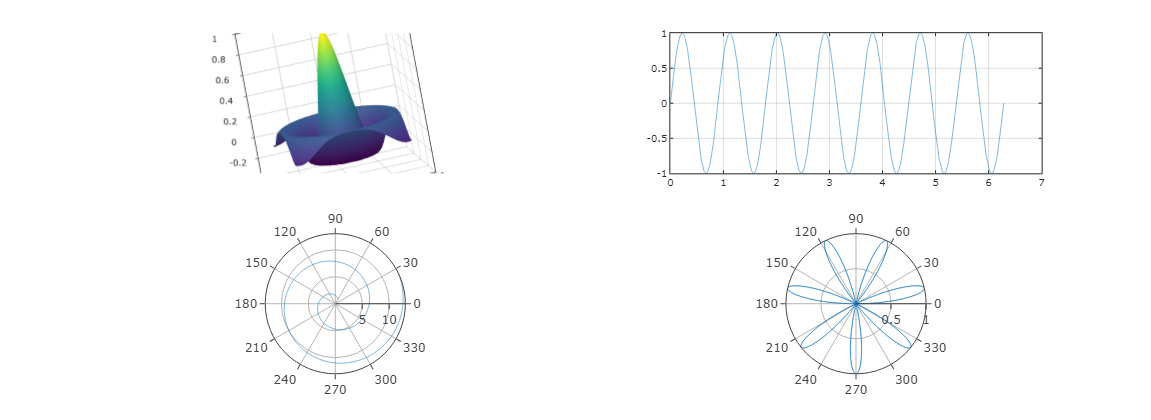

In [10]:
graphics_toolkit("plotly")

a = [1:0.1:13];
theta = linspace (0,2*pi,1000);
rho = sin (7*theta);

subplot(2,2,1);
sombrero()
grid on;
box on;

subplot(2,2,2);
plot(theta, rho);
grid on;
box on;

subplot(2,2,3);
polar(a,a)
grid on;
box on;

subplot(2,2,4);
polar(theta, rho);
grid on;
box on;